# Opening a Chinese restaurant in Delhi

In [1]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


# Get geocoordinates of Delhi, India

In [2]:
# get coordinates of delhi
delhi_address = 'Delhi, India'

geolocator = Nominatim(user_agent="delhi_explorer")
location = geolocator.geocode(delhi_address)
latitude = location.latitude
longitude = location.longitude
delhi_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(delhi_address, latitude, longitude))

The geograpical coordinate of Delhi, India are 28.6517178, 77.2219388.


# Get sub districts of delhi and map them with population

In [3]:
url="https://raw.githubusercontent.com/sumyak/IBM-Capstone-Project/master/Capstone%20Project/Delhi_dataset.csv"
sector=pd.read_csv(url)
df_sector = pd.DataFrame(sector)
print(df_sector)
df_neighborhood=pd.read_csv("https://raw.githubusercontent.com/sumyak/IBM-Capstone-Project/master/Capstone%20Project/neighborhoods.csv")
print(df_neighborhood)




             SECTOR                                    SUB_DIVISION POPULATION
0     Central Delhi                  Daryaganj,Paharganj,Karol Bagh   5,78,671
1       North Delhi                 Sadar Bazar,Kotwali,Civil Lines   8,83,418
2       South Delhi                Kalkaji,Defense Colony,Hauz Khas  27,33,752
3        East Delhi            Gandhi Nagar,Preet Vihar,Vivek Vihar  17,07,725
4  North East Delhi           Shahdara,Naveen Shadara,Rohtash Nagar  22,40,749
5  South West Delhi         Vasant Vihar,Najafgarh,Delhi Cantonment  22,92,363
6         New Delhi  Connaught Place,Parliament Street,Chanakyapuri   1,33,713
7  North West Delhi               Saraswati Vihar,Narela,Model Town  36,51,261
8        West Delhi         Patel Nagar,Punjabi Bagh,Rajouri Garden  25,31,583
          Sub_Divison             Sector Sector_Population
0           Daryaganj      Central Delhi          5,78,671
1           Paharganj      Central Delhi          5,78,671
2          Karol Bagh      Centra

#  Get geographical coordinates of neighborhoods 

In [5]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,delhi_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Sub_Divison"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head(5)

Geographical coordinates of five neighborhoods are as below


,Sub_Divison,Sector,Sector_Population,Latitude,Longitude
0,Daryaganj,Central Delhi,"5,78,671",28.628320,77.247270
1,Paharganj,Central Delhi,"5,78,671",28.645960,77.214920
2,Karol Bagh,Central Delhi,"5,78,671",28.650450,77.188730
3,Sadar Bazar,North Delhi,"8,83,418",28.590280,77.120140
4,Kotwali,North Delhi,"8,83,418",28.598039,77.128206


#  Create Delhi map with neighborhoods superimposed

In [6]:
#create map of Delhi neighborhoods using latitude and longitude values
map_delhi= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Sub_Divison']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

# Load Venues and Analyze Neighborhoods in Delhi

In [7]:
# we will use Foursqure API here

LIMIT = 100
CLIENT_ID = 'S3N1EOXFANGIHWZ0NPJ21OZJ0A2INSCC3V4ZGLHX4JWOWEE3' # your Foursquare ID
CLIENT_SECRET = 'C3O1FJ5QSKCR4WDL0UI0H5ZWVXHYTT5ZDJDE0EW4ISWRXQG5' # your Foursquare Secret
VERSION = '20180604'
def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Sub_Divison'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 125 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Daryaganj,28.62832,77.24727,Indira Gandhi Indoor Stadium,50704245e4b017acd538a775,28.633323,77.247618,557,Stadium
1,Daryaganj,28.62832,77.24727,McDonald's,5433b331498ec8da8a612d0b,28.632432,77.241012,763,Fast Food Restaurant
2,Daryaganj,28.62832,77.24727,fabindia,4dc14928e4cda3b87f1dadb6,28.629612,77.244705,288,Clothing Store
3,Daryaganj,28.62832,77.24727,Killer ITO Xing,4c4998e26594be9a07764925,28.627666,77.241253,592,Plaza
4,Daryaganj,28.62832,77.24727,Pearey Lal Bhawan,4e4fb7c318383eb2af24c06f,28.628233,77.241488,565,Performing Arts Venue


In [8]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Indian Restaurant,59
Hotel,37
Café,34
Fast Food Restaurant,27
Coffee Shop,27
Chinese Restaurant,20
Pizza Place,20
Restaurant,14
Bar,14


## Filter restaurants out of all venues

In [9]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
Chinese_restaurant_list = ['Chinese Restaurant', 'Dinner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
Chinese_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(Chinese_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(Chinese_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Chinese restaurants:', len(Chinese_restaurants['VenueId'].unique()))
print('Percentage of Chinese restaurants: {:.2f}%'.format(len(Chinese_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 229
Total number of Chinese restaurants: 20
Percentage of Chinese restaurants: 8.73%


18 neighborhoods do not have any Chinese restaurant


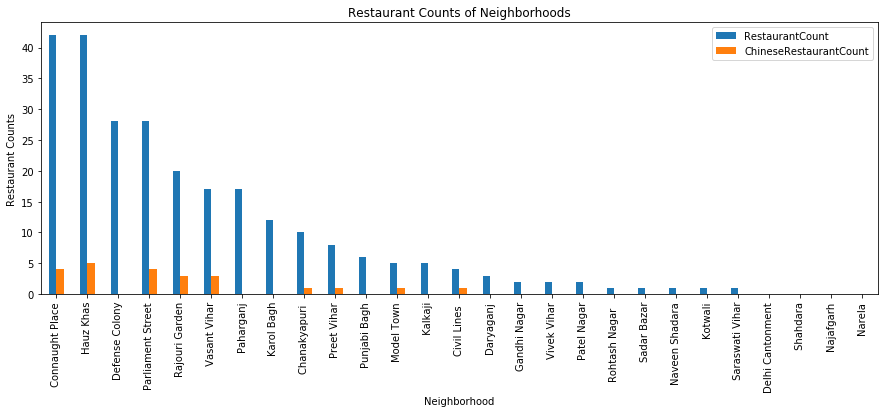

In [10]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Chinese restaurants in each Neighborhood
df_Chinese_rest_counts =  Chinese_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "ChineseRestaurantCount"})[['ChineseRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(Chinese_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_Chinese_rest_counts = df_Chinese_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'ChineseRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_Chinese_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_Chinese_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Chinese restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','ChineseRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

### We can see from the graph
+ Connaught place and Hauz Khaz have most restaurants and chinese restaurants also.
+ 20 neighbors dont have chinese restaurants.
+ shandara,najafgarh,narela and delhi cantonment dont have restaurants at all.
+ chanakyapuri,preet vihar and civil lines have the least chinese restaurants.


# Get the restaurant's overall rating using Foursquare API

In [11]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()


,VenueId,VenueRating,VenueLikes
0,5433b331498ec8da8a612d0b,6.7,4.0
1,4d5e367329ef236a4ab38959,NaN,NaN
2,4d9bdc2b913a236a4930a908,NaN,NaN
3,537dcc4b498ec171ba24b0d0,7.2,6.0
4,5654478f498e405c3e4e0d6a,7.7,15.0


In [12]:

restaurants_raitings = restaurants_raitings.replace(np.nan, 0)

print(restaurants_raitings)

                      VenueId  VenueRating  VenueLikes
0    5433b331498ec8da8a612d0b          6.7         4.0
1    4d5e367329ef236a4ab38959          0.0         0.0
2    4d9bdc2b913a236a4930a908          0.0         0.0
3    537dcc4b498ec171ba24b0d0          7.2         6.0
4    5654478f498e405c3e4e0d6a          7.7        15.0
5    4ef092caa69ddc7bcc2172fe          7.4        10.0
6    545503ad498e75ddfe4728c3          6.8         6.0
7    4ea6658893ad76dfdb5f6463          7.3         8.0
8    5664419d38fa76efbc532650          6.9        13.0
9    52ce86c1498ed4eed58394a9          6.7        23.0
10   528f0e51498e607d55fd73c4          6.5         1.0
11   4e2fd531ae60231c0330b531          6.7         7.0
12   4ce796c6948f224ba51feb5d          6.4        24.0
13   516f8839e4b06f1af7fcc960          6.3         3.0
14   50909840e4b045f7566ce837          5.9        10.0
15   4f154120e4b0fd295229e2b5          6.1         0.0
16   4c2cbdd1d1a10f47a5e6f964          6.1        15.0
17   4e2be

In [13]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Daryaganj,28.62832,77.24727,McDonald's,5433b331498ec8da8a612d0b,28.632432,77.241012,763,Fast Food Restaurant,6.7,4.0
1,Daryaganj,28.62832,77.24727,Udupi Cafe,4d5e367329ef236a4ab38959,28.630797,77.241259,648,Udupi Restaurant,0.0,0.0
2,Daryaganj,28.62832,77.24727,Mocha @ Wills India Fashion Week,4d9bdc2b913a236a4930a908,28.621093,77.247809,806,Café,0.0,0.0
3,Paharganj,28.64596,77.21492,The Indian Grill Restaurant,537dcc4b498ec171ba24b0d0,28.646141,77.215133,28,Restaurant,7.2,6.0
4,Paharganj,28.64596,77.21492,The Drunkyard Cafe,5654478f498e405c3e4e0d6a,28.641451,77.215506,505,Tibetan Restaurant,7.7,15.0


In [14]:
#merge raitings to Chinese restaurants 
Chinese_restaurants = Chinese_restaurants.merge(restaurants_raitings)
Chinese_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Civil Lines,28.67671,77.21767,moets,4cd6d9d276ab721ed31b756a,28.678015,77.224739,705,Chinese Restaurant,6.8,4.0
1,Hauz Khas,28.55109,77.20399,Chopsticks,4d208b27756e8cfa193a6d54,28.552319,77.213119,903,Chinese Restaurant,0.0,0.0
2,Hauz Khas,28.55109,77.20399,Golden Dragon,4bd710bbcfa7b713f19028da,28.543780,77.208543,927,Chinese Restaurant,0.0,0.0
3,Hauz Khas,28.55109,77.20399,Chi Kitchen & Bar,4d54011565586ea8519471c8,28.546599,77.196422,893,Chinese Restaurant,0.0,0.0
4,Hauz Khas,28.55109,77.20399,Drums of Heaven,4d48297d0bfd548135ac3a00,28.557980,77.206033,792,Chinese Restaurant,0.0,0.0


In [15]:
#df_neighborhood_noturkrest['Sub_Divison'] = df_neighborhood_noturkrest['Sub_Divison'].astype(int)
#df_neighborhood_noturkrest['Sub_Divison'] = df_neighborhood_noturkrest['Sub_Divison'].astype(str).astype(int)
print(df_neighborhood['Sub_Divison'].dtypes)
x=df_neighborhood['Sub_Divison']
x=str(x)
print(type(x))
x=int(x)
print(type(x))

object
<class 'str'>


ValueError: invalid literal for int() with base 10: '0             Daryaganj\n1             Paharganj\n2            Karol Bagh\n3           Sadar Bazar\n4               Kotwali\n5          Civil Lines \n6               Kalkaji\n7        Defense Colony\

### Show restaurants on head map
+ Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Delhi on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Delhi center

+ Red markers are Chinese restaurants
+ Blue markers are Chinese restaurants with rating less than 7 restaurants

In [20]:

delhi_center = [latitude, longitude]
map_restaurant= folium.Map(location=delhi_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Sub_Divison'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_delhi) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(delhi_center).add_to(map_bucharest)
folium.Circle(delhi_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(delhi_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(delhi_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(delhi_center, radius=10000, fill=False, color='black').add_to(map_restaurant)

for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Sub_Divison']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

TypeError: must be real number, not str

#  Cluster Neigborhoods using Agglomerative Clustering

In [15]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

27  neighborhoods' venue category are shown in 125 columns as below


,Neighborhood,Stadium,Fast Food Restaurant,Clothing Store,Plaza,Performing Arts Venue,Udupi Restaurant,Café,Hotel,Historic Site,Train Station,Light Rail Station,Restaurant,Tibetan Restaurant,Korean Restaurant,Indian Restaurant,Food,Indian Chinese Restaurant,Motel,Hostel,Bar,Pizza Place,Snack Place,Breakfast Spot,Bakery,Coffee Shop,Sandwich Place,Road,Gift Shop,Construction & Landscaping,Dessert Shop,BBQ Joint,Food & Drink Shop,Gym / Fitness Center,Bed & Breakfast,Burrito Place,Motorcycle Shop,Farmers Market,Convenience Store,Shoe Store,Multiplex,Shopping Mall,Cafeteria,Chinese Restaurant,Donut Shop,Grocery Store,Trail,Asian Restaurant,Market,Bank,South Indian Restaurant,Italian Restaurant,Ice Cream Shop,French Restaurant,Arcade,Cocktail Bar,Burger Joint,Neighborhood,Indie Movie Theater,Food Truck,Movie Theater,Sporting Goods Shop,Afghan Restaurant,Spa,Other Nightlife,Karaoke Bar,Japanese Restaurant,Art Gallery,Mediterranean Restaurant,Theater,Nightclub,Tea Room,American Restaurant,Lounge,Beer Garden,Tapas Restaurant,Park,Event Space,Turkish Restaurant,Bagel Shop,Yoga Studio,Pool,Athletics & Sports,Shop & Service,Track,Diner,ATM,Chocolate Shop,Shipping Store,Vegetarian / Vegan Restaurant,Platform,Mobile Phone Shop,Men's Store,Speakeasy,Gourmet Shop,Department Store,Gym,Pub,Middle Eastern Restaurant,Nightlife Spot,Wine Bar,Pharmacy,Resort,Molecular Gastronomy Restaurant,Deli / Bodega,Bistro,North Indian Restaurant,Portuguese Restaurant,Gastropub,Salon / Barbershop,Jazz Club,Flea Market,Souvenir Shop,History Museum,Hotel Pool,Airport Terminal,Karnataka Restaurant,Moroccan Restaurant,Furniture / Home Store,Track Stadium,Electronics Store,Garden Center,Hookah Bar,Jewelry Store,Garden,Cosmetics Shop
0,Connaught Place,0,2,2,1,0,0,10,7,1,1,1,1,1,0,13,0,1,0,0,5,0,0,0,1,3,0,1,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,4,1,0,0,2,0,0,2,2,1,0,0,0,0,Connaught Place,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kalkaji,0,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,Kalkaji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Saraswati Vihar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Saraswati Vihar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Shahdara,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Shahdara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Vasant Vihar,0,2,0,0,0,0,3,1,0,0,0,2,0,0,2,0,0,0,0,0,2,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,1,1,0,0,1,0,0,0,1,0,Vasant Vihar,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:

# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhoods','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))
        
 

 # create a new dataframe
venues_most = pd.DataFrame(columns = columns)




'''
for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()
'''

ValueError: Incompatible indexer with Series

### Cluster and find similarities between neighborhoods
#### I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

#### First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset